# Drivers of Reddit NBA sentiment
This notebook investigates what drives the sentiment of NBA players on reddit. It roughly has N parts:
1. Building a set of covariates for sentiment (e.g. player demographics, city demographics, performance data)
2. Calculating the sentiment towards each player
3. Performing a regression model to predict player sentiment

This is a work in progress. For similar work on the NFL, see `nfl-sentiment.ipynb`.

For the most fun, I would skip to **Exploration of sentiment values**

### Weekend to-do:
Fuzzy match comments to coaches
Re-factor notebooks into
1. Scraping and covariates
2. Sentiment analysis
3. Regression

### Long term to-do:
Create functions for:
  * fuzzy matching cleanup
  * aggregation (maybe)

Get Twitter data for comparison

In [1]:
import json
import string
import re
import pandas as pd
import numpy as np
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
from ast import literal_eval
from string import punctuation
from sner import Ner
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import matplotlib.pyplot as plt
%matplotlib inline

C:\Users\map22\Anaconda3\lib\site-packages\nltk\twitter\__init__.py:20: UserWarning: The twython library has not been installed. Some functionality from the twitter package will not be available.
  warnings.warn("The twython library has not been installed. "


In [2]:
import sports_sentiment as ss
import scrape_player_data as spd

In [3]:
pd.set_option('display.max_colwidth', 100)
pd.set_option('display.max_columns', 100)

## Constants and non-text data

In [4]:
non_players_set = set('Atlanta Hawks Boston Celtics Brooklyn Nets Charlotte Bobcats ' \
                  'Chicago Bulls Cleveland Cavaliers cavs Dallas Mavericks mavs Denver Nuggets ' \
                  'Detroit Pistons Golden State Warriors Houston Rockets Indiana '\
                  'Pacers Los Angeles LA Clippers LA Lakers LAL Memphis Grizzlies Miami Heat '\
                  'Milwaukee Bucks Minnesota Timberwolves  New Orleans Hornets New York Knicks NYK '\
                  'Oklahoma City Thunder Orlando Magic Philadelphia Sixers 76ers Phoenix '\
                  'Suns Portland Trail Blazers Sacramento Kings '\
                  'San Antonio Spurs Toronto Raptors Utah Jazz Washington Wizards wiz '\
                      'NBA asg KOC woj shams'.lower().split())

In [5]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_race.tsv', sep='\t')
coaches = set([name for coach in list(coaches_race_df.iloc[:,0]) for name in coach.split(' ')] )

### Instantiate sentiment analyzer
For sentiment, I use a modified version of VADER. Many words have different sentiment in the sports world as compared to general usage (e.g. "offensive" is not a negative word in sports).

In [6]:
sid = SentimentIntensityAnalyzer()
stat_words = ['steal', 'steals', 'block', 'blocked', 'blocks', 'slam', 'charges', 'rejection', 'free', 'assists', 'win']
neutral_words = ['offense', 'offensive', 'offensively', 'defense', 'defensive', 'defensively', 'defender',
                 'injury', 'injured', 'strain', 'questionable', 'isolation',
                 'shoot', 'doubtful', 'play', 'plays', 'crazy', 'turnover', 'turnovers',
                 'seriously', 'loss', 'losses', 'playing', 'vicious',]
bad_words = ['foul', 'ridiculous', 'motherfucking', 'mediocre', 'soft', 'slow', 'delusional']
great_words = ['goat', 'nasty', 'prime', 'mvp']
sid.lexicon.update({word:0.1 for word in stat_words})
sid.lexicon.update({word:0 for word in neutral_words})
sid.lexicon.update({word:-0.5 for word in bad_words})
sid.lexicon.update({word:1 for word in great_words})

#### Player names for entity recognition and fuzzy matching
When extracting named entities, I had to be careful with some names that are common English words (e.g. "Brown"). As a shorter alternative to performing NER, I also sometimes simply extracted player names as keywords.

In [7]:
covariates_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_player_covariates.tsv', sep='\t')
covariates_df.head(2)

,Player,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,Unnamed: 19,OWS,DWS,WS,WS/48,Unnamed: 24,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,season,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,alex abrines,W,2017,2018,G-F,78,190,"August 1, 1993",NaN,1,SG,23,68,1055,10.1,0.560,0.724,0.144,1.9,7.1,4.5,5.5,1.7,0.6,8.3,15.9,NaN,1.2,0.9,2.1,0.096,NaN,-0.3,-2.2,-2.5,-0.1,OKC,2.0,5.0,0.393,1.4,3.6,0.381,0.6,1.4,0.426,0.531,0.6,0.7,0.898,0.3,1.0,1.3,0.6,0.5,0.1,0.5,1.7,6.0,2017,2016,47,1337075,74.1,10.2,0.1051,5994764.0,49.481519,0
1,steven adams,W,2014,2018,C,84,255,"July 20, 1993",University of Pittsburgh,3,C,23,80,2389,16.5,0.589,0.002,0.392,13.0,15.4,14.2,5.4,1.8,2.6,16.0,16.2,NaN,3.3,3.1,6.5,0.130,NaN,-0.7,1.2,0.6,1.5,OKC,4.7,8.2,0.571,0.0,0.0,0.000,4.7,8.2,0.572,0.571,2.0,3.2,0.611,3.5,4.2,7.7,1.1,1.1,1.0,1.8,2.4,11.3,2017,2016,47,1337075,74.1,10.2,0.1051,3140517.0,42.096917,3


In [8]:
UNIQUE_NAMES = set(covariates_df.Player.unique())
UNIQUE_NAMES = UNIQUE_NAMES.union(set(coaches_race_df.iloc[:,0]))

In [9]:
NAMED_ENTITIES = set(' '.join(UNIQUE_NAMES).split()).union({'lma', 'kd', 'lbj', 'klove', 'drose', 'kobe',
                                            'mj', 'magic', 'bird', 'wilt', 'chamberlain',
                                            'tt', 'shump', 'kat', 'melo', 'k-love', 'd-wade', 'dwade',
                                            'boogie', 'bosh', 'iggy', 'mcbuckets', 'cp3'})
# some players have common word names; don't want to detect those as entities when lowercase, but do want to when uppercase
UPPER_ENTITIES = {'Black', 'Ball' 'Buddy', 'Grant', 'House', 'Smart', 'Holiday', 'Love', 'Rose',
                  'Smart', 'Stone', 'Temple', 'Wall', 'Will', 'Wear', 'Case', 'New', 'Little',
                  'Shorts', 'City', 'Will', 'Young', 'Gay', 'Price', 'World', 'Peace', 'Long', 'Semi',
                  'Brown', 'Green', 'Blue', 'White', 'Brand', 'Early'}
NAMED_ENTITIES = NAMED_ENTITIES - {'a'} - {name.lower() for name in UPPER_ENTITIES}
table = str.maketrans({key: None for key in string.punctuation})
NOPUNCT_ENTITIES = {name.translate(table) for name in NAMED_ENTITIES}
NAMED_ENTITIES = NAMED_ENTITIES.union(NOPUNCT_ENTITIES)
NAMED_ENTITIES = NAMED_ENTITIES.union(non_players_set)
NAMED_ENTITIES = NAMED_ENTITIES.union(coaches)

### Load covariates

In [10]:
text_col = 'sentences'
def create_month_df(data_loc):
    return ss.create_sentiment_df(data_loc, sid.polarity_scores, ner_set=NAMED_ENTITIES,
                                  non_players_set=non_players_set, UPPER_NAMES = UPPER_ENTITIES, TEXT_COL = text_col)[1]

## Calculate sentiment 
### Reddit sentiment for 2017-18 season
I created a module, `sentiment_sports` to calculate the sentiment of comments. This function performs a few things:
1. Separates comments into sentences
2. Performs Named entity recognition using either NLTK, or using pre-existing list of entities
3. Calculates sentiment using VADER with a modified lexicon

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv.gz'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201710, 201711, 201712, 201801, 201802, 201803, 201804, 201805]]
nba2017_df = pd.concat(year_dfs)
nba2017_df.shape

In [33]:
%%time
nba2017_df = ss.fuzzy_match_players(nba2017_df, UNIQUE_NAMES)

Fuzzy matching player names
Wall time: 4min 1s


In [56]:
nba2017_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2016 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
oct_df = create_month_df(file_stub.format(201610))
nov_df = create_month_df(file_stub.format(201611))
dec_df = create_month_df(file_stub.format(201612))
jan_df = create_month_df(file_stub.format(201701))
feb_df = create_month_df(file_stub.format(201702) + '.gz')
mar_df = create_month_df(file_stub.format(201703) + '.gz')
apr_df = create_month_df(file_stub.format(201704) + '.gz')
may_df = create_month_df(file_stub.format(201705) + '.gz')

In [48]:
nba2016_df = pd.concat([oct_df, nov_df, dec_df, jan_df, feb_df, mar_df, apr_df, may_df])
nba2016_df.shape
# previously 888k

(603886, 15)

In [49]:
nba2016_df = ss.fuzzy_match_players(nba2016_df, UNIQUE_NAMES)

Fuzzy matching player names


In [73]:
nba2016_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2016.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2015 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201510, 201511, 201512, 201601, 201602, 201603, 201604, 201605]]
nba2015_df = pd.concat(year_dfs)
nba2015_df.shape

In [54]:
nba2015_df = ss.fuzzy_match_players(nba2015_df, UNIQUE_NAMES)

Fuzzy matching player names


In [64]:
nba2015_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2014 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201411, 201412, 201501, 201502, 201503, 201504, 201505]]
nba2014_df = pd.concat(year_dfs)
nba2014_df.shape

In [60]:
nba2014_df = ss.fuzzy_match_players(nba2014_df, UNIQUE_NAMES)

Fuzzy matching player names


In [21]:
nba2014_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2014.tsv', sep='\t',
               index=False, encoding = 'utf-8')

#### 2013 season

In [ ]:
%%time
file_stub = 'd:/data/sentiment_sports/nba_reddit_comments/{}-comments_submissions.tsv'
year_dfs = [create_month_df(file_stub.format(year)) for year in [201311, 201312, 201401, 201402, 201404, 201405]]
nba2013_df = pd.concat(year_dfs)
nba2013_df.shape

In [74]:
nba2013_df = ss.fuzzy_match_players(nba2013_df, UNIQUE_NAMES)

Fuzzy matching player names


In [32]:
nba2013_df.to_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2013.tsv', sep='\t',
               index=False, encoding = 'utf-8')

### Load comment sentiment data

In [11]:
nba2013_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2013.tsv',sep='\t', encoding = 'utf-8')
nba2013_df['named_entities'] = nba2013_df['named_entities'].apply(literal_eval)
nba2014_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2014.tsv',sep='\t', encoding = 'utf-8')
nba2014_df['named_entities'] = nba2014_df['named_entities'].apply(literal_eval)
nba2015_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2015.tsv',sep='\t', encoding = 'utf-8')
nba2015_df['named_entities'] = nba2015_df['named_entities'].apply(literal_eval)
nba2016_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2016.tsv',sep='\t', encoding = 'utf-8')
nba2016_df['named_entities'] = nba2016_df['named_entities'].apply(literal_eval)
nba2017_df = pd.read_csv('d:/data/sentiment_sports/combined_months_ner_sentiment_2017.tsv',sep='\t', encoding = 'utf-8').drop(columns='Unnamed: 0')
nba2017_df['named_entities'] = nba2017_df['named_entities'].apply(literal_eval)

C:\Users\map22\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (1,2,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [12]:
nba2013_df['season'] = 2013
nba2014_df['season'] = 2014
nba2015_df['season'] = 2015
nba2016_df['season'] = 2016
nba2017_df['season'] = 2017

In [30]:
nba_df = pd.concat([nba2013_df, nba2014_df, nba2015_df, nba2016_df, nba2017_df])

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  """Entry point for launching an IPython kernel.


#### Cleaning up name matches
Some extracted name entities don't have a clear match (e.g. "Rivers" could be Austin Rivers or Doc Rivers). Here we clean those out

In [31]:
name_map = {name:'unclear' for name in ['rivers', 'bird', 'draymond sessions', 'jalen jalen', 'brown markelle', 'kyrie korver', 'kyrie singler',
                    'wade drummond', 'kyrie anderson', 'kyle irving', 'kyle ingles', 'kyle turner', 'kyle turner', 'jabari maker',
                    'walton walton', 'nene kanter', 'courtney love', 'george will', 'charles charles', 'jason aaron', 'lebron jae',
                    'sterling lebron', 'bobby lebron', 'damien', 'cleveland', 'cleveland cleveland', 'ben ben', 'martin', "o'bryant",
                           'sam sam', 'shaquille shaquille', 'blue', 'jamal curry', 'david westbrook', 'griffin baker', 'chris pau',
                           'jimmy tyler', 'jamal curry', 'jamal curry' 'london','jackson tatum', 'ball', 'early', 'phil', 'world', 'peace',
                            'wilt', 'wallace', 'leaf', 'billy', 'jalen']}
name_map.update({'giannis':'giannis antetokounmpo', 'kd':'kevin durant', 'kd kd': 'kevin durant',
                 'lbj':'lebron james', 'lma':'lamarcus aldridge', 
                 'shump': 'iman shumpert', 'blake': 'blake griffin',
                 'kat': 'karl-anthony towns', 'dwight': 'dwight howard',
                 'boogie':'demarcus cousins', 'demar': 'demar derozan',
                'klove':'kevin love', 'cj': 'cj mccollum', 'shabazz': 'shabazz muhammad',
                'ingram': 'brandon ingram', 'manu': 'manu ginobili', 'thon': 'thon maker',
                'simmons': 'ben simmons', 'ben': 'ben simmons', 'jj':'jj redick',
                'wade': 'dwyane wade', 'nance jr': 'larry nance', 'pau':'pau gasol',
                 'mbah moute': 'luc mbah a moute', 'luc': 'luc mbah a moute',
                'lin': 'jeremy lin', 'iggy':'andre iguodala', 'lue':'tyronn lue', 'tt':'tristan thompson',
                'hayward': 'gordon hayward', 'lonzo':'lonzo ball', 'mj':'michael jordan',
                 'mcbuckets':'doug mcdermott', 'cp3':'chris paul'})

In [32]:
%%time
nba_df['fuzzy_name'] = nba_df.apply(lambda row: name_map[row['str_entities']] if row['str_entities'] in name_map else row['fuzzy_name'], axis=1)

Wall time: 1min 34s


Remove players whose names have implicit sentiment

In [33]:
senti_players = ['jerian grant', 'jerami grant', 'marcus smart', 'justin holiday','jrue holiday', 'kevin love', 'derrick favors']
nba_df = nba_df[nba_df['fuzzy_name'].apply(lambda row: row not in senti_players)]

In [34]:
match_df = nba_df.query('fuzzy_name != "unclear"')
match_df.shape

(2623671, 17)

### User-level metrics

In [35]:
user_df = match_df.groupby('user').agg({'score':['sum', 'count', 'mean']}).fillna(0)
user_df.columns = ['user_total_score', 'user_total_comments', 'user_mean_score']

## Calculating sentiment towards each player
#### First calculate the average sentiment for each player from each user
A naive approach might simply average the sentiment across all comments; this approach would be biased towards the sentiment of the most common posters. Instead, I calculated the sentiment towards each player by each user, then in a second step averaged the sentiment across users.

In [36]:
user_player_sentiment_df = (match_df.groupby(['fuzzy_name', 'user', 'flair', 'season'])
                                    .agg({'compound':['mean', 'std', 'count']})
                                    .reset_index())
user_player_sentiment_df.columns = ['fuzzy_name', 'user', 'flair', 'season', 'compound_mean', 'compound_std', 'comment_count']
user_player_sentiment_df['fuzzy_name'] = user_player_sentiment_df['fuzzy_name'].str.replace('\.', '')
user_player_sentiment_df.head(2)

,fuzzy_name,user,flair,season,compound_mean,compound_std,comment_count
0,aaron brooks,2RealNeal,Pacers,2015,0.0,0.0,2
1,aaron brooks,2RealNeal,Pacers,2016,0.0,0.0,2


#### Match user flairs to teams

In [37]:
flair_dict = {'Celtics':'BOS', 'Cavaliers':'CLE', 'Lakers':'LAL', 'Raptors':'TOR', 'Warriors':'GSW',
              'Spurs':'SAS', '76ers':'PHI', 'Knicks':'NYK', 'Rockets':'HOU', 'Bulls':'CHI', 'Thunder':'OKC',
              'Trail Blazers':'POR', 'Timberwolves':'MIN', 'Heat':'MIA', 'Wizards':'WAS', 'Jazz':'UTA',
              'Bucks':'MIL', 'Mavericks':'DAL', 'Pistons':'DET', 'Kings':'SAC',
              'Suns':'PHO', 'Clippers':'LAC', 'Hawks':'ATL',
              'Hornets':'CHO', 'Nuggets':'DEN', 'Pacers':'IND',
              'Pelicans':'NOP', 'Nets':'BRK', 'Magic':'ORL', 'Grizzlies':'MEM'}
def get_flair(flair_string, flair_dict, flair_regex):
    ''' Match flairs that are team name, or have team abbreviation within brackets'''
    if flair_string in flair_dict:
        return flair_dict[flair_string]
    elif re.match(flair_regex, flair_string):
        return re.search(flair_regex, flair_string).groups(1)[0]
    return 'no_team'
flair_regex = '^\[(\w{3})\]'
user_player_sentiment_df['user_Tm'] = user_player_sentiment_df['flair'].apply(lambda row: get_flair(row, flair_dict, flair_regex))

In [38]:
# city demographics
city_df = pd.read_csv('d:/data/sentiment_sports/covariates/sports_metro_demographics.csv').drop(columns = ['census_Id', 'census_Id2', 'Geography'])
vote_df = pd.read_csv('d:/data/sentiment_sports/covariates/msa_votes.tsv', sep='\t')[['per_point_diff', 'Tm']].rename(columns={'per_point_diff':'clinton_vote_lead'})

In [39]:
user_player_regression_df = (user_player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'season'], how = 'left')
                         .merge(user_df, on='user', how='left')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24']))
user_player_regression_df['team_match'] = user_player_regression_df['Tm'] == user_player_regression_df['user_Tm']
user_player_regression_df = (user_player_regression_df.drop(columns = ['metro_percent_white', 'metro_percent_black', 'clinton_vote_lead', 'total_population'])
                                    .merge(vote_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left')
                                    .merge(city_df.rename(columns = {'Tm':'user_Tm'}), on='user_Tm', how='left'))
user_player_regression_df['youth'] = (user_player_regression_df['Age'].mean() - user_player_regression_df['Age']).clip(0)
user_player_regression_df['oldness'] = (user_player_regression_df['Age'] - user_player_regression_df['Age'].mean()).clip(0)
user_player_regression_df['rookie'] = user_player_regression_df['experience'] <=4
user_player_regression_df['ThreePP'] =user_player_regression_df['ThreePP'].fillna(user_player_regression_df['ThreePP'].mean())
user_player_regression_df['white_black_diff'] = user_player_regression_df['metro_percent_white'] - user_player_regression_df['metro_percent_black']
user_player_regression_df['height_dummies'] = pd.cut(user_player_regression_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])
user_player_regression_df.to_csv('d:/data/sentiment_sports/nba_user_player_sentiment.tsv', sep='\t', index=False)

#### Then calculate the average sentiment to players across all users

In [40]:
player_sentiment_df = (user_player_sentiment_df.query('compound_mean != 0')
                                               .groupby(['fuzzy_name', 'season'])
                                               .agg({'compound_mean':['mean', 'std', 'count']})
                                               .reset_index() )
player_sentiment_df.columns = ['fuzzy_name', 'season', 'compound_mean_mean', 'compound_mean_std', 'user_count']

## Exploration of sentiment values
Plot of player popularity (number of users who comment on them), versus sentiment

Text(0,0.5,'Mean sentiment')

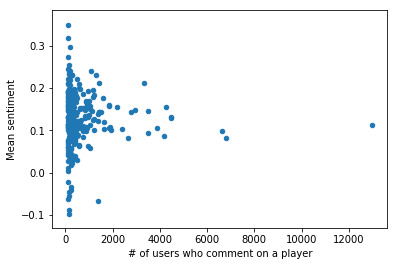

In [24]:
player_sentiment_df.query('user_count> 100 and season ==2017').plot('user_count', 'compound_mean_mean', kind='scatter')
#plt.plot([100, 100], [-0.1, 0.3])
plt.xlabel('# of users who comment on a player')
plt.ylabel('Mean sentiment')

#### Most commented players

In [123]:
player_sentiment_df.query('season ==2017').sort_values('user_count', ascending=False).head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1271,lebron james,2017,0.113005,0.341995,13000
1157,kevin durant,2017,0.082803,0.379252,6838
835,james harden,2017,0.097981,0.365911,6635
1236,kyrie irving,2017,0.130130,0.383307,4491
1189,kobe bryant,2017,0.129677,0.381968,4475


#### Players with lowest sentiment
Sterling Brown's sentiment probably reflects a combination of sentiment towards police and himself. Other players on this list like Zaza Pachulia and Salah Mejri are well known disliked players.

In [124]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').head()

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1452,mike dunleavy,2016,-0.108050,0.470797,238
1129,kelly olynyk,2016,-0.078625,0.468706,491
1870,steve blake,2015,-0.070948,0.441219,226
2124,zaza pachulia,2017,-0.066168,0.438263,1397
664,fred hoiberg,2016,-0.064798,0.455466,219


In [125]:
player_sentiment_df = player_sentiment_df.query('fuzzy_name != "sterling brown"')

#### Players with highest sentiment
This list seems biased towards players with relatively low comment counts

In [161]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_mean').tail(5)

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
953,jj redick,2015.0,0.262868,0.355104,905
954,jj redick,2016.0,0.273153,0.351860,639
1655,rakeem christmas,2015.0,0.283326,0.411077,448
356,coty clarke,2017.0,0.295706,0.408073,209
197,brandon ingram,2015.0,0.304735,0.320630,202


#### Players with highest std of sentiment
Again, this appears biased towards players with relatively low comment counts.

In [127]:
player_sentiment_df.query('user_count > 200').sort_values('compound_mean_std').tail(5).iloc[::-1]

,fuzzy_name,season,compound_mean_mean,compound_mean_std,user_count
1166,kevin mchale,2017,0.056949,0.485148,222
1401,matt barnes,2016,0.001354,0.480636,244
1623,paul pierce,2017,0.031773,0.479982,424
1400,matt barnes,2015,0.020281,0.477218,262
1147,kenny atkinson,2016,0.100645,0.474739,272


## Explore demographics relationship with sentiment
#### Join player sentiment to performance and demographics
To see how sentiment is related to demographics, we can join the sentiment table above with the player demographics dataframe `covariates_df`.

I include only players with at least 50 comments to remove noise

In [41]:
join_df = (player_sentiment_df.rename(columns = {'fuzzy_name':'Player'})
                         .merge(covariates_df, on = ['Player', 'season'], how = 'left')
                          .drop(columns=['Unnamed: 19', 'Unnamed: 24'])).query('user_count > 10')

#### Sentiment versus performance
Surprisingly, there seems to be relatively little correlation between player performance and sentiment towards the player

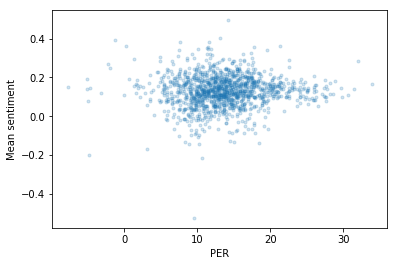

In [204]:
plt.plot(join_df['PER'].values, join_df['compound_mean_mean'].values, '.',alpha= 0.2);
plt.xlabel('PER')
plt.ylabel('Mean sentiment');

#### Sentiment and race
On average, sentiment towards black players is slightly lower than towards white players

In [43]:
join_df.groupby('Race').mean()

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
Race,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A,2015.333333,0.123920,0.407876,678.000000,2012.166667,2018.000000,76.666667,201.666667,301.333333,26.166667,46.333333,1173.500000,13.450000,0.517167,0.346000,0.420333,2.066667,9.750000,5.950000,22.366667,1.400000,2.483333,17.416667,23.200000,1.116667,0.950000,2.066667,0.058667,-1.783333,-1.683333,-3.450000,0.433333,3.650000,8.716667,0.387500,0.966667,2.650000,0.340000,2.716667,6.083333,0.428333,0.438667,3.283333,3.766667,0.819333,0.333333,1.916667,2.233333,3.483333,0.683333,0.416667,2.100000,2.166667,11.516667,2016.333333,39.333333,1.143310e+07,62.033333,16.250000,0.377250,7.760301e+06,49.217093,4.166667
B,2015.066667,0.132644,0.418036,300.166337,2010.790099,2017.570297,78.489109,218.212541,245.724092,26.537294,57.172277,1370.796700,13.563762,0.527919,0.295552,0.269777,4.749307,14.557756,9.656040,13.555908,1.646403,1.635974,13.015476,19.261452,1.492343,1.384884,2.877228,0.082000,-0.980000,-0.286271,-1.265941,0.733465,3.462508,7.713465,0.444204,0.793201,2.266733,0.304476,2.670033,5.447195,0.482188,0.494175,1.595842,2.101716,0.741924,0.886865,2.858614,3.742376,2.045809,0.724818,0.424158,1.259934,1.803960,9.309967,2016.066667,41.062046,5.456652e+06,67.202310,15.629835,0.376936,5.814123e+06,43.953207,5.276568
L,2014.181818,0.044844,0.434746,102.545455,2008.000000,2016.363636,80.000000,236.363636,354.636364,30.636364,40.000000,818.636364,10.836364,0.481182,0.293636,0.259091,5.900000,14.963636,10.463636,15.818182,1.600000,1.500000,15.609091,15.954545,0.772727,0.754545,1.536364,0.065727,-2.036364,0.036364,-2.000000,0.281818,2.209091,5.236364,0.401818,0.554545,1.736364,0.212889,1.654545,3.518182,0.431000,0.447273,0.727273,1.018182,0.646182,0.881818,2.454545,3.318182,1.972727,0.554545,0.318182,0.981818,1.845455,5.672727,2015.181818,46.181818,5.703959e+06,62.590909,17.000000,0.372373,5.771912e+06,46.552692,7.181818
M,2014.910256,0.120667,0.424613,409.089744,2010.307692,2017.358974,77.448718,208.282051,246.000000,27.115385,56.307692,1475.141026,14.647436,0.523513,0.299808,0.224654,4.101282,13.488462,8.834615,20.152564,1.811538,1.038462,13.746154,20.265385,2.183333,1.515385,3.694872,0.094064,0.057692,-0.321795,-0.262821,1.212821,4.106410,9.012821,0.438808,1.105128,2.893590,0.328987,2.998718,6.125641,0.462897,0.494308,1.670513,2.175641,0.737720,0.837179,2.871795,3.711538,3.137179,0.819231,0.314103,1.508974,1.856410,10.982051,2015.910256,44.641026,7.528010e+06,61.698718,11.994872,0.408442,7.982262e+06,47.407005,5.602564
R,2016.250000,0.008167,0.468114,106.750000,2016.500000,2018.000000,83.250000,241.250000,323.500000,28.500000,54.000000,638.250000,13.625000,0.592250,0.123250,0.444750,9.650000,22.100000,15.725000,5.150000,1.425000,5.875000,18.650000,13.625000,0.575000,1.125000,1.725000,0.119000,-3.575000,3.275000,-0.300000,0.300000,1.250000,2.375000,0.562000,0.125000,0.350000,0.171750,1.150000,2.025000,0.565750,0.582250,0.600000,1.025000,0.585750,1.050000,2.275000,3.325000,0.400000,0.325000,0.800000,0.625000,1.650000,3.275000,2017.250000,38.500000,6.400053e+06,71.600000,13.475000,0.292175,1.009611e+06,31.299630,0.750000
W,2015.020833,0.123279,0.413995,199.404167,2011.243750,2017.477083,81.239583,231.891667,245.270833,27.120833,56.945833,1201.231250,13.513958,0.542533,0.284471,0.283508,6.151458,17.112083,11.628750,11.565208,1.330625,1.875000,14.055439,17.638125,1.450833,1.262083,2.713333,0.092277,-1.172708,-0.106042,-1.274583,0.548542,2.855417,6.156458,0.460636,0.640833,1.738542,0.300343,2.215833,4.416042,0.492036,0.511793,1.233958,1.634167,0.743004,1.031042,2.947708,3.976250,1.528958,0.511875,0.4339

#### Sentiment and age / experience
Generally, sentiment seems to be higher for young and old players (where there is selection bias in that skilled / popular players have longer careers).

(0, 20)

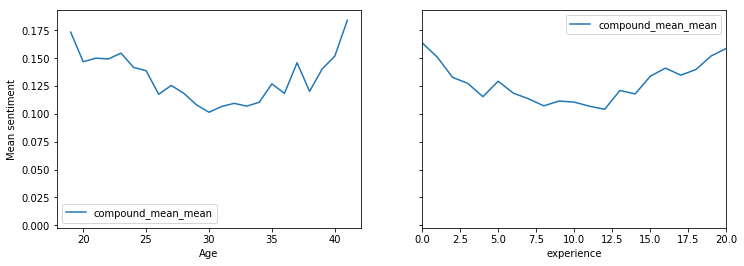

In [45]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Age').mean().reset_index().plot('Age', 'compound_mean_mean', ax = ax1);
join_df.groupby('experience').mean().reset_index().plot('experience', 'compound_mean_mean', ax = ax2);
ax1.set_ylabel('Mean sentiment')
ax2.set_xlim([0, 20])

#### Height

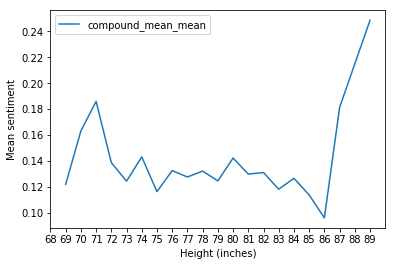

In [46]:
join_df.groupby('Ht').mean().reset_index().plot('Ht', 'compound_mean_mean');
plt.xticks(range(68,90,1) );
plt.xlabel('Height (inches)')
plt.ylabel('Mean sentiment');

### Team and position

In [47]:
join_df.groupby('Pos_y').mean().reset_index()

,Pos_y,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
0,C,2015.080189,0.127240,0.412885,283.396226,2010.818396,2017.481132,83.165094,252.667453,251.242925,26.853774,56.212264,1199.827830,16.021462,0.559175,0.062513,0.379558,10.050708,21.929481,15.987736,8.685613,1.317689,3.689858,14.893853,17.917925,1.764151,1.659434,3.421226,0.120934,-1.669104,1.394340,-0.273113,0.865094,3.185142,6.134434,0.521780,0.151651,0.450000,0.183662,3.032075,5.682075,0.535258,0.531496,1.464858,2.147170,0.679904,1.740802,3.943160,5.683255,1.125472,0.503538,0.859198,1.131840,2.113679,7.986557,2016.080189,41.408019,5.818303e+06,66.827830,15.131840,0.396315,6.518804e+06,45.832231,5.261792
1,PF,2015.028436,0.124910,0.420658,257.727488,2010.644550,2017.511848,81.398104,238.289100,250.296209,26.665877,57.286730,1281.362559,14.063744,0.534707,0.243171,0.277574,7.132701,18.529621,12.827014,8.986256,1.382701,2.050000,12.163333,18.481517,1.489573,1.451422,2.942417,0.094678,-1.304976,0.088863,-1.213033,0.659242,3.278436,6.991232,0.464352,0.570616,1.643365,0.284523,2.709005,5.352607,0.500647,0.505476,1.368009,1.880569,0.709347,1.251422,3.422512,4.667773,1.264218,0.561611,0.518246,1.031991,1.883649,8.492891,2016.028436,40.995261,5.624361e+06,66.805687,15.584597,0.378788,5.909005e+06,44.813372,5.383886
2,PF-C,2015.500000,0.147759,0.433112,164.500000,2010.500000,2018.000000,83.000000,237.500000,199.500000,28.500000,70.000000,1090.000000,12.750000,0.547500,0.484500,0.159000,5.600000,19.400000,12.500000,9.750000,1.250000,1.200000,11.900000,16.800000,1.000000,1.200000,2.250000,0.097000,-0.900000,-0.450000,-1.350000,0.200000,2.150000,4.900000,0.439000,0.900000,2.400000,0.362000,1.250000,2.500000,0.514000,0.529500,0.550000,0.750000,0.743500,0.750000,2.700000,3.450000,1.000000,0.400000,0.250000,0.700000,1.500000,5.750000,2016.500000,41.000000,1.832792e+06,72.650000,13.250000,0.175750,4.951374e+06,44.830567,6.000000
3,PF-SF,2013.500000,0.316700,0.404843,28.000000,2010.500000,2018.000000,80.000000,232.500000,365.000000,26.500000,63.000000,1246.500000,8.150000,0.479500,0.069000,0.285500,5.400000,10.000000,7.650000,6.250000,1.400000,0.750000,14.200000,14.100000,-0.350000,0.600000,0.300000,0.017500,-3.550000,-0.500000,-4.050000,-0.750000,2.150000,5.050000,0.431500,0.100000,0.350000,0.276500,2.050000,4.800000,0.444500,0.440500,0.950000,1.300000,0.707000,0.950000,1.750000,2.700000,0.850000,0.550000,0.150000,0.900000,1.350000,5.300000,2014.500000,28.500000,1.175994e+07,69.500000,12.450000,0.562550,2.762694e+06,38.697417,4.000000
4,PG,2015.107143,0.131733,0.418354,296.771429,2011.204762,2017.607143,74.269048,188.809524,265.516667,26.652381,55.628571,1374.376190,13.645476,0.510578,0.336451,0.247217,2.113333,10.380952,6.239524,25.972143,1.895952,0.621667,15.622434,20.784762,1.597143,1.200714,2.797619,0.071036,-0.327143,-1.189286,-1.515714,0.777619,3.557857,8.378333,0.413516,0.972857,2.766667,0.328962,2.588333,5.607381,0.449707,0.470704,1.778810,2.205476,0.783049,0.445714,2.152619,2.598810,3.934286,0.856429,0.179762,1.669048,1.706429,9.861190,2016.107143,40.319048,5.513283e+06,67.291190,15.913571,0.370629,5.468586e+06,42.805174,4.902381
5,PG-SG,2015.000000,0.074906,0.426930,221.666667,2013.000000,2017.666667,74.333333,196.666667,244.666667,23.666667,53.000000,1340.000000,13.633333,0.521000,0.369000,0.292333,1.700000,10.300000,6.000000,22.933333,1.900000,0.433333,14.000000,20.900000,1.000000,1.200000,2.200000,0.074667,0.033333,-1.466667,-1.400000,0.400000,3.766667,9.166667,0.403667,1.200000,3.366667,0.340000,2.566667,5.800000,0.437667,0.467333,2.166667,2.600000,0.817000,0.366667,2.333333,2.733333,3.666667,0.933333,0.166667,1.800000,1.833333,10.866667,2016.00

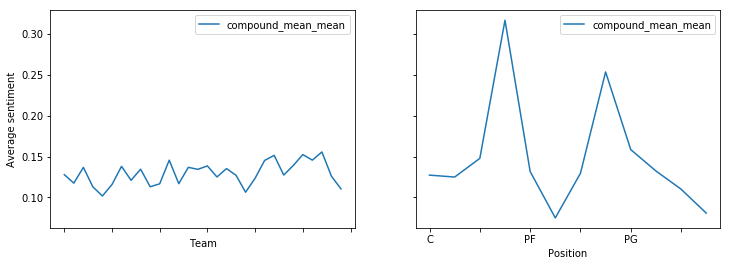

In [48]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize = [12, 4], sharey=True)
join_df.groupby('Tm').mean().reset_index().plot('Tm', 'compound_mean_mean', ax = ax1);
ax1.set_xlabel('Team')
ax1.set_ylabel('Average sentiment')
join_df.groupby('Pos_y').mean().reset_index().plot('Pos_y', 'compound_mean_mean', ax = ax2);
ax2.set_xlabel('Position')
ax2.set_xticklabels(['', 'C','', 'PF','', 'PG','', 'SF','', 'SG']);

In [49]:
join_df.groupby('Tm').mean().sort_values('compound_mean_mean').head(2)

,season,compound_mean_mean,compound_mean_std,user_count,From,To,Ht,Wt,Rk,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience
Tm,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
CHO,2015.461538,0.101735,0.416010,152.403846,2011.519231,2017.634615,79.000000,219.134615,297.750000,26.192308,59.326923,1375.442308,14.084615,0.531981,0.289808,0.311346,4.669231,15.575000,10.044231,13.353846,1.348077,1.759615,11.096154,19.290385,1.380769,1.561538,2.944231,0.094846,-0.903846,-0.146154,-1.055769,0.698077,3.273077,7.484615,0.438308,0.801923,2.280769,0.349362,2.473077,5.207692,0.468808,0.4895,1.648077,2.140385,0.774635,0.859615,3.055769,3.903846,1.905769,0.578846,0.455769,1.025000,1.578846,8.988462,2016.461538,37.961538,2381152.0,68.4,22.2,0.2987,6.164587e+06,46.148283,4.942308
NYK,2014.972973,0.106361,0.416154,264.148649,2010.635135,2017.405405,79.364865,223.216216,249.418919,27.243243,56.364865,1281.445946,13.698649,0.524178,0.260521,0.241671,5.517568,15.440541,10.433784,13.341892,1.501351,1.960811,13.783562,18.783784,1.213514,0.914865,2.125676,0.070649,-1.014865,-0.463514,-1.479730,0.339189,3.312162,7.418919,0.444342,0.695946,1.959459,0.295284,2.622973,5.460811,0.471014,0.4900,1.379730,1.775676,0.762644,0.986486,2.848649,3.829730,1.854054,0.606757,0.470270,1.156757,1.860811,8.697297,2015.972973,29.243243,20031443.0,58.7,17.1,0.7720,5.709133e+06,43.256331,5.337838


#### Create modeling dataframe

In [128]:
join_df = join_df.dropna(subset = ['TOVP'])

In [ ]:
join_df['youth'] = (join_df['Age'].mean() - join_df['Age']).clip(0)
join_df['oldness'] = (join_df['Age'] - join_df['Age'].mean()).clip(0)
join_df['rookie'] = join_df['experience'] <=1

In [ ]:
join_df['ThreePP'] =join_df['ThreePP'].fillna(join_df['ThreePP'].mean())
join_df['white_black_diff'] = join_df['metro_percent_white'] - join_df['metro_percent_black']

In [131]:
join_df['height_dummies'] = pd.cut(join_df['Ht'], [0, 72, 79, 100], labels = ['short', 'medium', 'tall'])

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [132]:
#join_df.to_csv('modeling_data/nba_player_model_data.tsv', sep='\t', index=False)
join_df = pd.read_csv('modeling_data/nba_player_model_data.tsv', sep='\t')

In [133]:
fit_df = join_df.replace({'M':'B', 'L':'W'}).query('Race == "W" or Race == "B"').query('user_count > 20')#

In [134]:
fit_df.head(2)

,Player,season,compound_mean_mean,compound_mean_std,user_count,Race,From,To,Pos_x,Ht,Wt,Birth Date,Colleges,Rk,Pos_y,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,DRB%,TRBP,ASTP,STLP,BLKP,TOVP,USG%,OWS,DWS,WS,WS/48,OBPM,DBPM,BPM,VORP,Tm,FG,FGA,FG%,3P,3PA,ThreePP,2P,2PA,2P%,eFG%,FT,FTA,FT%,ORB,DRB,TRB,AST,STL,BLK,TOV,PF,PPG,year,Wins,total_population,metro_percent_white,metro_percent_black,clinton_vote_lead,salary,standard_salary,experience,youth,oldness,rookie,white_black_diff,height_dummies
0,aaron brooks,2013,-0.029754,0.467124,70,B,2008.0,2018.0,G,72.0,161.0,"January 14, 1985",University of Oregon,65.0,PG,29.0,72.0,1557.0,12.5,0.518,0.427,0.164,3.1,6.7,4.9,23.3,1.6,0.6,15.8,20.5,1.3,0.9,2.2,0.067,0.4,-1.9,-1.5,0.2,HOU,3.2,8.1,0.401,1.3,3.4,0.387,1.9,4.6,0.411,0.484,1.2,1.3,0.874,0.6,1.3,1.9,3.2,0.7,0.2,1.6,2.0,9.0,2014.0,54.0,6482592.0,65.7,17.2,0.1240,1027424.0,31.837388,6.0,0.0,2.278124,False,48.5,short
1,aaron brooks,2014,0.014116,0.497695,82,B,2008.0,2018.0,G,72.0,161.0,"January 14, 1985",University of Oregon,63.0,PG,30.0,82.0,1885.0,14.4,0.534,0.383,0.213,1.9,7.5,4.8,24.2,1.5,0.6,14.9,25.0,1.7,1.5,3.3,0.083,1.0,-2.4,-1.4,0.3,CHI,4.2,10.0,0.421,1.5,3.8,0.387,2.7,6.1,0.442,0.495,1.8,2.1,0.833,0.4,1.6,2.0,3.2,0.7,0.2,1.9,2.3,11.6,2015.0,50.0,9528396.0,66.3,16.9,0.5296,915243.0,30.930298,7.0,0.0,3.278124,False,49.4,short


## Regression models

### Salary

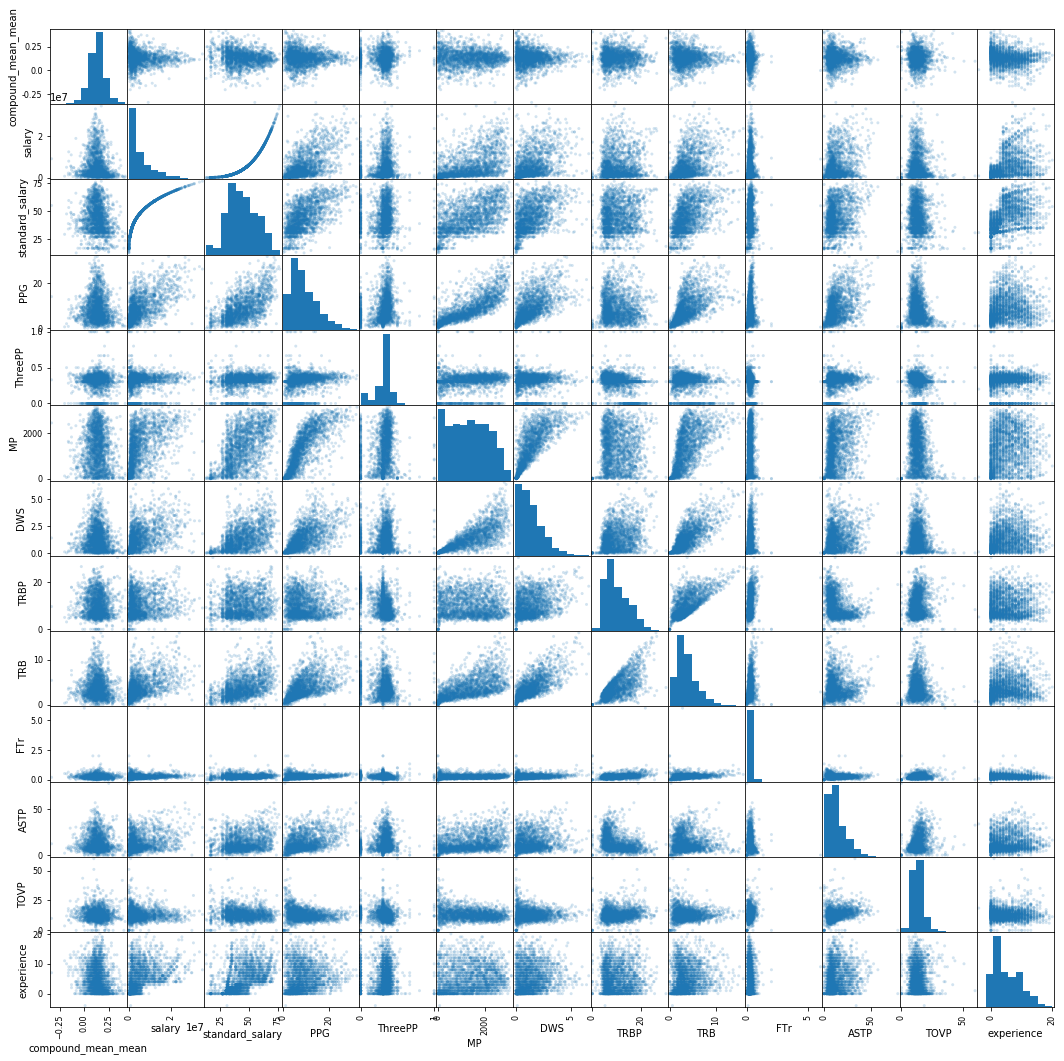

In [135]:
from pandas.plotting import scatter_matrix
scatter_matrix(join_df[['compound_mean_mean', 'salary', 'standard_salary', 'PPG',
                        'ThreePP', 'MP', 'DWS', 'TRBP', 'TRB', 'FTr', 'ASTP', 'TOVP', 'experience']], alpha=0.2, figsize=(18, 18));

In [136]:
salary_model = smf.wls( formula = 'standard_salary ~ rookie + MP + PPG + ThreePP + DWS + TRBP * height_dummies + AST + BLKP * height_dummies + STLP + TOVP',
                data = fit_df,
               weights = fit_df['G'],
#                missing='raise'   
               ).fit()

In [137]:
salary_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:        standard_salary   R-squared:                       0.473
Model:                            WLS   Adj. R-squared:                  0.468
Method:                 Least Squares   F-statistic:                     98.18
Date:                Thu, 20 Dec 2018   Prob (F-statistic):          1.32e-229
Time:                        23:08:00   Log-Likelihood:                -6410.3
No. Observations:                1769   AIC:                         1.285e+04
Df Residuals:                    1752   BIC:                         1.295e+04
Df Model:                          16                                         
Covariance Type:            nonrobust                                         
=================================================================================================
                                    coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
Intercept                        14.0916      4.902      2.875      0.004       4.477      23.706
rookie[T.True]                   -9.2433      0.520    -17.773      0.000     -10.263      -8.223
height_dummies[T.medium]         23.9294      4.735      5.054      0.000      14.643      33.216
height_dummies[T.tall]           25.0346      4.745      5.276      0.000      15.728      34.342
MP                                0.0010      0.001      1.682      0.093      -0.000       0.002
PPG                               0.6967      0.068     10.233      0.000       0.563       0.830
ThreePP                          -1.6293      1.880     -0.867      0.386      -5.317       2.058
DWS                               0.6302      0.337      1.873      0.061      -0.030       1.290
TRBP                              3.9133      0.855      4.577      0.000       2.236       5.590
TRBP:height_dummies[T.medium]    -4.0932      0.865     -4.731      0.000      -5.790      -2.396
TRBP:height_dummies[T.tall]      -3.7265      0.860     -4.332      0.000      -5.414      -2.039
AST                               0.9500      0.201      4.727      0.000       0.556       1.344
BLKP                             -5.0349      4.233     -1.190      0.234     -13.336       3.267
BLKP:height_dummies[T.medium]     5.9464      4.257      1.397      0.163      -2.403      14.295
BLKP:height_dummies[T.tall]       4.5035      4.234      1.064      0.288      -3.801      12.808
STLP                             -1.9348      0.401     -4.826      0.000      -2.721      -1.149
TOVP                              0.0967      0.070      1.387      0.165      -0.040       0.233
==============================================================================
Omnibus:                        9.341   Durbin-Watson:                   1.364
Prob(Omnibus):                  0.009   Jarque-Bera (JB):                9.429
Skew:                          -0.169   Prob(JB):                      0.00896
Kurtosis:                       2.886   Cond. No.                     7.37e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 7.37e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Calculate residual salary

In [138]:
fit_df['pred_std_salary'] = salary_model.predict(fit_df)
fit_df['std_salary_resid'] = fit_df['pred_std_salary']- fit_df['standard_salary']
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
2126,justin patton,2017,38.718985,6.599973,4.0,2.0,1.0
1372,gordon hayward,2017,73.839893,42.560347,5.0,2.0,1.0
2499,luol deng,2017,64.390081,37.047860,13.0,2.0,1.0
1865,joakim noah,2017,64.921912,39.444358,40.0,1.7,7.0
544,chandler parsons,2016,68.577291,44.545475,675.0,6.2,34.0


There is a big problem using rate states where low sample size is causing funky predicted salary. I think the best way to handle this would be to shrink the salary residuals based on # of games played, but I'm not 100% sure how to do that. So I will set the salary residual for all players with < 20 games to be 0.

In [139]:
fit_df.loc[ fit_df['G'] <20, 'std_salary_resid'] = 0
fit_df.sort_values('std_salary_resid').head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
544,chandler parsons,2016,68.577291,44.545475,675.0,6.2,34.0
545,chandler parsons,2017,69.336099,45.958715,691.0,7.9,36.0
3042,paul millsap,2017,74.478198,51.670050,1143.0,14.6,38.0
3825,ty lawson,2015,59.394307,37.317588,1411.0,5.7,66.0
1468,ian mahinmi,2016,63.245553,41.362111,555.0,5.6,31.0


Most underpaid players

In [140]:
fit_df.sort_values('std_salary_resid', ascending=False).head(5)[['Player', 'season', 'standard_salary', 'pred_std_salary', 'MP', 'PPG', 'G']]

,Player,season,standard_salary,pred_std_salary,MP,PPG,G
2924,nikola jokic,2017,34.828226,61.682652,2443.0,18.5,75.0
541,chandler parsons,2013,31.024969,57.265481,2783.0,16.6,74.0
2691,michael beasley,2015,23.529724,48.490456,363.0,12.8,20.0
2742,mike james,2017,20.148403,44.999483,687.0,9.3,36.0
2359,lance stephenson,2013,31.474285,55.023636,2752.0,13.8,78.0


Some player salaries didn't get joined correctly due to name (e.g. Schroder vs Schroeder)

In [141]:
fit_df['std_salary_resid'] =fit_df['std_salary_resid'].fillna(fit_df['std_salary_resid'].mean())

### Sentiment regression models
First, a regression model for sentiment with features for performance, age, team wins, race, and height.

In [166]:
model = smf.wls( formula = 'compound_mean_mean ~ MP + PPG + ThreePP + DWS + TRBP + FTr+ ASTP + BLKP + STLP + TOVP + ' \
                'youth + oldness + C(rookie) + C(height_dummies) + std_salary_resid + C(Race)*PPG', \
#                       ' PPG +  + total_population+  * white_black_diff + C(Race) * clinton_vote_lead',
                data = fit_df,
               weights = 1 / (fit_df['compound_mean_std'] / np.sqrt(fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : fit_df['Player']})

In [167]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.100
Model:                            WLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     7.698
Date:                Thu, 20 Dec 2018   Prob (F-statistic):           4.24e-19
Time:                        23:18:16   Log-Likelihood:                 2359.2
No. Observations:                1837   AIC:                            -4678.
Df Residuals:                    1817   BIC:                            -4568.
Df Model:                          19                                         
Covariance Type:              cluster                                         
===============================================================================================
                                  coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept                       0.1475      0.017      8.916      0.000       0.115       0.180
C(rookie)[T.True]               0.0249      0.006      4.221      0.000       0.013       0.037
C(height_dummies)[T.medium]    -0.0238      0.014     -1.761      0.078      -0.050       0.003
C(height_dummies)[T.tall]      -0.0198      0.015     -1.362      0.173      -0.048       0.009
C(Race)[T.W]                   -0.0277      0.011     -2.430      0.015      -0.050      -0.005
MP                          -5.316e-06   4.42e-06     -1.203      0.229    -1.4e-05    3.35e-06
PPG                             0.0005      0.001      0.909      0.363      -0.001       0.002
C(Race)[T.W]:PPG                0.0029      0.001      2.423      0.015       0.001       0.005
ThreePP                         0.0208      0.016      1.287      0.198      -0.011       0.052
DWS                             0.0015      0.003      0.496      0.620      -0.004       0.007
TRBP                           -0.0017      0.001     -2.450      0.014      -0.003      -0.000
FTr                            -0.0010      0.009     -0.107      0.915      -0.019       0.017
ASTP                           -0.0002      0.000     -0.720      0.471      -0.001       0.000
BLKP                            0.0031      0.002      1.981      0.048    3.21e-05       0.006
STLP                            0.0051      0.003      1.853      0.064      -0.000       0.010
TOVP                           -0.0009      0.000     -2.099      0.036      -0.002   -6.16e-05
youth                           0.0044      0.002      2.141      0.032       0.000       0.008
youth:PPG                   -6.959e-05      0.000     -0.547      0.584      -0.000       0.000
oldness                         0.0011      0.001      1.181      0.237      -0.001       0.003
std_salary_resid                0.0002      0.000      0.724      0.469      -0.000       0.001
==============================================================================
Omnibus:                      100.117   Durbin-Watson:                   1.134
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              187.935
Skew:                          -0.394   Prob(JB):                     1.55e-41
Kurtosis:                       4.355   Cond. No.                     2.11e+04
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 2.11e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [307]:
predicted_senti = model.predict(fit_df[['PER', 'youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall']])

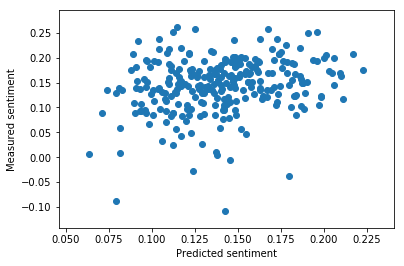

In [308]:
plt.scatter(predicted_senti, fit_df['compound_mean_mean'])
plt.xlabel('Predicted sentiment')
plt.ylabel('Measured sentiment');

## Coaches

In [22]:
coaches_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_performance.tsv', sep='\t')
coaches_race_df = pd.read_csv('d:/data/sentiment_sports/covariates/nba_coach_race.tsv', sep='\t')
coaches_df['Tm'] = coaches_df['Tm'].replace({'CHA':'CHO'})

In [23]:
team_win_df = coaches_df.groupby(['Tm', 'season']).sum()['W'].reset_index()
team_win_df['season_WinP_prev'] = team_win_df['W'] / 82

In [24]:
coach_tenure = coaches_df.groupby(['Tm', 'Coach']).apply(lambda df: df.rank())[['season']].rename(columns={'season':'tenure'})
coaches_df = coaches_df.join(coach_tenure)
coaches_df['rookie'] = coaches_df['tenure'] == 1

In [25]:
coaches_df['prev_season'] = coaches_df['season']-1
coaches_df = coaches_df.merge(team_win_df.rename(columns = {'season': 'prev_season'}),
                              on = ['prev_season', 'Tm'], how='left', suffixes = ('', '_prev') )
coaches_df['winP_change'] = (coaches_df['season_WinP'] - coaches_df['season_WinP_prev']).fillna(0)

In [29]:
coaches_covariates_df = (coaches_df.merge(coaches_race_df, on = 'Coach')
                                   .rename(columns = {'Coach':'fuzzy_name'})
                                   .merge(player_sentiment_df, on = ['fuzzy_name', 'season'], how='inner')
                                   )

### Most and least popular coaches

In [30]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).query('user_count > 40').head(5)

,season,age,league,Tm,G,W,L,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_season,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
102,2014,38.0,NBA,BOS,82,40.0,42.0,0.488,0.540,brad stevens,2.0,False,2013,25.0,0.304878,0.183122,W,0.306124,0.379665,224
98,2014,44.0,NBA,MIA,82,37.0,45.0,0.451,0.599,erik spoelstra,7.0,False,2013,54.0,0.658537,-0.207537,W,0.262563,0.407600,75
105,2017,41.0,NBA,BOS,82,55.0,27.0,0.671,0.540,brad stevens,5.0,False,2016,53.0,0.646341,0.024659,W,0.240317,0.395893,1093
59,2014,49.0,NBA,GSW,82,67.0,15.0,0.817,0.809,steve kerr,1.0,True,2013,51.0,0.621951,0.195049,W,0.234521,0.405996,806
53,2014,40.0,NBA,MEM,82,55.0,27.0,0.671,0.504,dave joerger,2.0,False,2013,50.0,0.609756,0.061244,W,0.232666,0.390662,94


In [31]:
coaches_covariates_df.sort_values('compound_mean_mean',ascending=False).query('user_count > 40').tail(5)

,season,age,league,Tm,G,W,L,season_WinP,career_WinP,fuzzy_name,tenure,rookie,prev_season,W_prev,season_WinP_prev,winP_change,race,compound_mean_mean,compound_mean_std,user_count
44,2016,44.0,NBA,CHI,82,41.0,41.0,0.500,0.440,fred hoiberg,2.0,False,2015,42.0,0.512195,-0.012195,B,-0.064798,0.455466,219
43,2015,43.0,NBA,CHI,82,42.0,40.0,0.512,0.440,fred hoiberg,1.0,True,2014,50.0,0.609756,-0.097756,B,-0.064798,0.455466,219
84,2015,57.0,NBA,NYK,28,9.0,19.0,0.321,0.284,kurt rambis,1.0,True,2014,17.0,0.207317,0.113683,W,-0.097748,0.466934,59
127,2017,38.0,NBA,PHO,3,0.0,3.0,0.000,0.280,earl watson,3.0,False,2016,24.0,0.292683,-0.292683,B,-0.100618,0.463179,56
58,2015,63.0,NBA,SAC,82,33.0,49.0,0.402,0.588,george karl,2.0,False,2014,29.0,0.353659,0.048341,W,-0.150630,0.448509,144


### Filter to coaches with enough games and comments and explore data

In [32]:
coaches_fit_df = coaches_covariates_df.query('G >= 10 and user_count > 10')
coaches_fit_df['age'] = coaches_fit_df['age'].fillna(coaches_fit_df['age'].mean())
coaches_covariates_df.to_csv('modeling_data/nba_coaches_covariates.tsv', sep='\t', index=False)

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


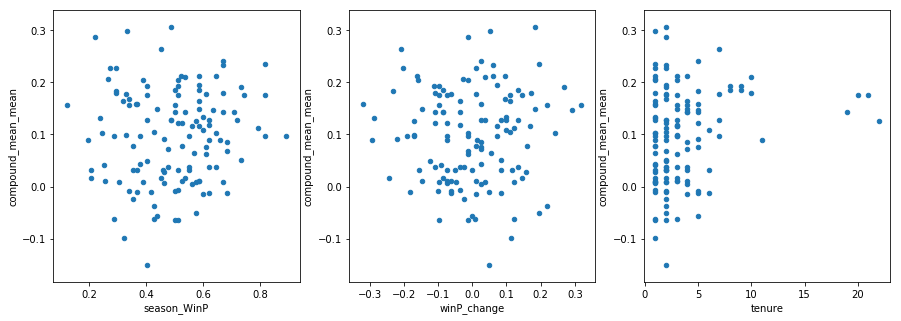

In [102]:
fig, axes = plt.subplots(1,3, figsize = [15, 5])
coaches_fit_df.plot.scatter('season_WinP', 'compound_mean_mean', ax = axes[0]);
coaches_fit_df.plot.scatter('winP_change', 'compound_mean_mean', ax = axes[1]);
coaches_fit_df.plot.scatter('tenure', 'compound_mean_mean', ax = axes[2]);

In [38]:
coaches_fit_df.groupby('race').agg(['mean', 'count'])[['compound_mean_mean', 'tenure', 'season_WinP', 'age']]

compound_mean_mean          tenure       season_WinP              age  \
                   mean count      mean count        mean count       mean   
race                                                                         
B              0.061738    39  2.333333    39    0.468256    39  48.128205   
W              0.112593    89  4.101124    89    0.506697    89  52.118115   

            
     count  
race        
B       39  
W       89

#### Coaches model - no clustering

In [104]:
'''model = sm.WLS( fit_df['compound_mean_mean'].values,
               fit_df[['youth', 'oldness', 'Wins', 'W', 'M', 'short', 'tall',
                       'PS/G', '3P%' , 'TRB%', 'AST%','BLK%', 'STL%', 'OWS', 'DWS']],
               fit_df['user_count']).fit()'''
coach_model = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + career_WinP + winP_change +season_WinP + C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit()

In [105]:
coach_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.313
Model:                            WLS   Adj. R-squared:                  0.272
Method:                 Least Squares   F-statistic:                     7.793
Date:                Fri, 14 Dec 2018   Prob (F-statistic):           9.27e-08
Time:                        22:41:50   Log-Likelihood:                 149.64
No. Observations:                 128   AIC:                            -283.3
Df Residuals:                     120   BIC:                            -260.5
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
==================================================================================
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2365      0.052      4.564      0.000       0.134       0.339
rookie[T.True]     0.0174      0.018      0.984      0.327      -0.018       0.053
C(race)[T.W]       0.0628      0.015      4.226      0.000       0.033       0.092
age               -0.0048      0.001     -5.104      0.000      -0.007      -0.003
tenure             0.0081      0.002      3.733      0.000       0.004       0.012
career_WinP        0.0278      0.096      0.291      0.772      -0.161       0.217
winP_change        0.0549      0.070      0.789      0.432      -0.083       0.193
season_WinP        0.0373      0.077      0.482      0.631      -0.116       0.190
==============================================================================
Omnibus:                        1.677   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.432   Jarque-Bera (JB):                1.431
Skew:                          -0.102   Prob(JB):                        0.489
Kurtosis:                       2.524   Cond. No.                     1.00e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large,  1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Coaches model - full - with clustered errors

In [34]:
coaches_fit_df['demean_winP'] = coaches_fit_df['season_WinP'] - coaches_fit_df['season_WinP'].mean()

C:\Users\map22\Anaconda3\lib\site-packages\ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [35]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ age + tenure + rookie + career_WinP + winP_change + demean_winP * C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [36]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.313
Model:                            WLS   Adj. R-squared:                  0.266
Method:                 Least Squares   F-statistic:                     4.895
Date:                Sun, 16 Dec 2018   Prob (F-statistic):           0.000187
Time:                        12:25:55   Log-Likelihood:                 149.64
No. Observations:                 128   AIC:                            -281.3
Df Residuals:                     119   BIC:                            -255.6
Df Model:                           8                                         
Covariance Type:              cluster                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.2551      0.082      3.116      0.002       0.095       0.415
rookie[T.True]               0.0175      0.020      0.881      0.378      -0.021       0.056
C(race)[T.W]                 0.0629      0.017      3.664      0.000       0.029       0.096
age                         -0.0048      0.001     -3.434      0.001      -0.008      -0.002
tenure                       0.0081      0.002      3.999      0.000       0.004       0.012
career_WinP                  0.0278      0.106      0.263      0.793      -0.180       0.235
winP_change                  0.0548      0.075      0.734      0.463      -0.091       0.201
demean_winP                  0.0386      0.095      0.408      0.683      -0.147       0.224
demean_winP:C(race)[T.W]    -0.0018      0.077     -0.023      0.981      -0.152       0.148
==============================================================================
Omnibus:                        1.683   Durbin-Watson:                   1.701
Prob(Omnibus):                  0.431   Jarque-Bera (JB):                1.436
Skew:                          -0.102   Prob(JB):                        0.488
Kurtosis:                       2.523   Cond. No.                     1.16e+03
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
[2] The condition number is large, 1.16e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### Coaches model - performance only - with clustered errors

In [109]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ career_WinP + winP_change +season_WinP',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [110]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.032
Model:                            WLS   Adj. R-squared:                  0.008
Method:                 Least Squares   F-statistic:                     1.221
Date:                Fri, 14 Dec 2018   Prob (F-statistic):              0.312
Time:                        22:45:46   Log-Likelihood:                 127.74
No. Observations:                 128   AIC:                            -247.5
Df Residuals:                     124   BIC:                            -236.1
Df Model:                           3                                         
Covariance Type:              cluster                                         
===============================================================================
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
Intercept       0.0398      0.038      1.042      0.298      -0.035       0.115
career_WinP     0.1321      0.124      1.067      0.286      -0.111       0.375
winP_change     0.0587      0.081      0.722      0.470      -0.101       0.218
season_WinP    -0.0178      0.099     -0.180      0.857      -0.211       0.175
==============================================================================
Omnibus:                        0.027   Durbin-Watson:                   1.297
Prob(Omnibus):                  0.987   Jarque-Bera (JB):                0.014
Skew:                           0.006   Prob(JB):                        0.993
Kurtosis:                       2.949   Cond. No.                         22.0
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

#### Coaches model - race and performance - with clustered errors

In [137]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ career_WinP + winP_change +season_WinP * C(race)',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [138]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.149
Model:                            WLS   Adj. R-squared:                  0.114
Method:                 Least Squares   F-statistic:                     3.800
Date:                Fri, 14 Dec 2018   Prob (F-statistic):            0.00558
Time:                        23:01:09   Log-Likelihood:                 135.96
No. Observations:                 128   AIC:                            -259.9
Df Residuals:                     122   BIC:                            -242.8
Df Model:                           5                                         
Covariance Type:              cluster                                         
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                    0.0505      0.053      0.956      0.339      -0.053       0.154
C(race)[T.W]                 0.0342      0.052      0.658      0.511      -0.068       0.136
career_WinP                 -0.0074      0.121     -0.062      0.951      -0.244       0.230
winP_change                 -0.0065      0.084     -0.078      0.938      -0.171       0.158
season_WinP                  0.0216      0.100      0.216      0.829      -0.175       0.218
season_WinP:C(race)[T.W]     0.0581      0.084      0.689      0.491      -0.107       0.223
==============================================================================
Omnibus:                        0.109   Durbin-Watson:                   1.549
Prob(Omnibus):                  0.947   Jarque-Bera (JB):                0.013
Skew:                          -0.024   Prob(JB):                        0.994
Kurtosis:                       3.008   Cond. No.                         31.9
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""

#### Coaches model - tenure and performance - with clustered errors

In [139]:
coach_model_clustered = smf.wls( formula = 'compound_mean_mean ~ career_WinP + winP_change +season_WinP + age + tenure + rookie',
                data = coaches_fit_df,
               weights = 1 / (coaches_fit_df['compound_mean_std'] / np.sqrt(coaches_fit_df['user_count'])),
#                missing='raise'   
               ).fit(cov_type='cluster', cov_kwds={'groups' : coaches_fit_df['fuzzy_name']})

In [140]:
coach_model_clustered.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:     compound_mean_mean   R-squared:                       0.210
Model:                            WLS   Adj. R-squared:                  0.171
Method:                 Least Squares   F-statistic:                     3.392
Date:                Fri, 14 Dec 2018   Prob (F-statistic):            0.00719
Time:                        23:04:06   Log-Likelihood:                 140.76
No. Observations:                 128   AIC:                            -267.5
Df Residuals:                     121   BIC:                            -247.6
Df Model:                           6                                         
Covariance Type:              cluster                                         
==================================================================================
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept          0.2488      0.092      2.691      0.007       0.068       0.430
rookie[T.True]     0.0104      0.020      0.528      0.598      -0.028       0.049
career_WinP        0.1612      0.115      1.402      0.161      -0.064       0.386
winP_change        0.1397      0.077      1.813      0.070      -0.011       0.291
season_WinP       -0.0573      0.084     -0.684      0.494      -0.221       0.107
age               -0.0048      0.002     -2.729      0.006      -0.008      -0.001
tenure             0.0094      0.002      4.131      0.000       0.005       0.014
==============================================================================
Omnibus:                        3.314   Durbin-Watson:                   1.478
Prob(Omnibus):                  0.191   Jarque-Bera (JB):                2.298
Skew:                          -0.145   Prob(JB):                        0.317
Kurtosis:                       2.412   Cond. No.                         940.
==============================================================================

Warnings:
[1] Standard Errors are robust tocluster correlation (cluster)
"""